In [1]:
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.linear_model import LinearRegression
import numpy as np

df = pd.read_csv('Employee.csv')
skew_age = df['Age'].skew()
skew_joiningyear = df['JoiningYear'].skew()

print(f"Skewness di age: {skew_age}")
print(f"Skewness di joiningyear: {skew_joiningyear}")

print("Matrice di correlazione:")
print(df.corr(numeric_only=True))
# niente correlazioni interne alle variabili numeriche

print("\nTest Chi-quadro rispetto alla variabile target 'leaveornot':")

cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop('leaveornot', errors='ignore')

for col in cat_cols:
    contingency = pd.crosstab(df[col], df['LeaveOrNot'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"{col}: Chi² = {chi2:.3f}, p-value = {p:.4f}")
# chi-quadro significativo per tutte le variabili categoriche: c'è associazione con la variabile target

print("\nCoefficiente di determinazione R² rispetto a 'leaveornot':")

num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop('LeaveOrNot', errors='ignore')

for col in num_cols:
    X = df[[col]]
    y = df['LeaveOrNot']
    model = LinearRegression().fit(X, y)
    r2 = model.score(X, y)
    print(f"{col}: R² = {r2:.3f}")
# R² molto basso in particolare per 'Age' e 'ExperienceInCurrentDomain'

print("\nCramer’s V per variabili categoriche rispetto a 'leaveornot':")
cat_cols = df.select_dtypes(include=['object', 'category']).columns.drop('leaveornot', errors='ignore')

for col in cat_cols:
    contingency = pd.crosstab(df[col], df['LeaveOrNot'])
    chi2, p, dof, expected = chi2_contingency(contingency)
    n = contingency.sum().sum()
    k = min(contingency.shape)  # numero minimo di categorie
    cramer_v = np.sqrt(chi2 / (n * (k - 1)))
    print(f"{col}: Cramer’s V = {cramer_v:.3f}, p-value = {p:.4f}")
# Cramer's V indica una bassa associazione per 'Education' e 'EverBenched'

Skewness di age: 0.9051951632077232
Skewness di joiningyear: -0.11346207232249321
Matrice di correlazione:
                           JoiningYear  PaymentTier       Age  \
JoiningYear                   1.000000    -0.096078  0.013165   
PaymentTier                  -0.096078     1.000000  0.007631   
Age                           0.013165     0.007631  1.000000   
ExperienceInCurrentDomain    -0.036525     0.018314 -0.134643   
LeaveOrNot                    0.181705    -0.197638 -0.051126   

                           ExperienceInCurrentDomain  LeaveOrNot  
JoiningYear                                -0.036525    0.181705  
PaymentTier                                 0.018314   -0.197638  
Age                                        -0.134643   -0.051126  
ExperienceInCurrentDomain                   1.000000   -0.030504  
LeaveOrNot                                 -0.030504    1.000000  

Test Chi-quadro rispetto alla variabile target 'leaveornot':
Education: Chi² = 101.830, p-value = 0

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# --- Copia del dataset originale per le trasformazioni ---
df_transformed = df.copy()

# --- Standardizzazione di joiningyear e Log trasformazione di age ---
scaler = StandardScaler()
df_transformed['JoiningYear_scaled'] = scaler.fit_transform(df_transformed[['JoiningYear']])
df_transformed['Age_log'] = np.log(df_transformed['Age'])
df_transformed.drop(columns=['JoiningYear', 'Age'], inplace=True)

# --- Calcolo skewness di age ---
skew_age = df_transformed['Age_log'].skew()
print(f"Skewness di age log-transform: {skew_age:.3f}")

# --- Creazione di un dataset senza alcune age, experienceincurrentdomain, education e everbenched ---
drop_cols = ['Age_log', 'ExperienceInCurrentDomain', 'Education', 'EverBenched']
df_reduced = df_transformed.drop(columns=drop_cols, errors='ignore')  # 'errors' evita errori se colonne non ci sono

# --- Label Encoding per le variabili categoriche ---
le = LabelEncoder()

# Per df_transformed (entire)
for col in df_transformed.select_dtypes(include=['object', 'category']).columns:
    df_transformed[col] = le.fit_transform(df_transformed[col])

# Per df_reduced
for col in df_reduced.select_dtypes(include=['object', 'category']).columns:
    df_reduced[col] = le.fit_transform(df_reduced[col])


# --- 70-30 Data Partition ---
# Per il dataset intero
X_entire = df_transformed.drop('LeaveOrNot', axis=1, errors='ignore')
y_entire = df_transformed['LeaveOrNot']
X_train_entire, X_test_entire, y_train_entire, y_test_entire = train_test_split(
    X_entire, y_entire, test_size=0.3, random_state=42, stratify=y_entire
)

# Per il dataset ridotto
X_reduced = df_reduced.drop(['LeaveOrNot', 'JoiningYear', 'age'], axis=1, errors='ignore')
y_reduced = df_reduced['LeaveOrNot']
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(
    X_reduced, y_reduced, test_size=0.3, random_state=42, stratify=y_reduced
)

print("\nData partition completata:")
print(f"Original dataset train shape: {X_train_entire.shape}, test shape: {X_test_entire.shape}")
print(f"Transformed dataset train shape: {X_train_reduced.shape}, test shape: {X_test_reduced.shape}")

Skewness di age log-transform: 0.693

Data partition completata:
Original dataset train shape: (3257, 8), test shape: (1396, 8)
Transformed dataset train shape: (3257, 4), test shape: (1396, 4)


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# --- Naive Bayes ---
print("\nModello: Naive Bayes")

# Dataset ENTIRE
nb_entire = GaussianNB()
nb_entire.fit(X_train_entire, y_train_entire)
y_pred_nb_entire = nb_entire.predict(X_test_entire)

# Dataset REDUCED
nb_reduced = GaussianNB()
nb_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_nb_reduced = nb_reduced.predict(X_test_reduced)

print("Modello Naive Bayes creato con successo.")

# --- Decision Tree ---
print("\nModello: Decision Tree")

dt_entire = DecisionTreeClassifier(random_state=42)
dt_entire.fit(X_train_entire, y_train_entire)
y_pred_dt_entire = dt_entire.predict(X_test_entire)

dt_reduced = DecisionTreeClassifier(random_state=42)
dt_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_dt_reduced = dt_reduced.predict(X_test_reduced)

print(f"Modello Decision Tree creato con successo.")

# --- Random Forest (100 alberi) ---
print("\nModello: Random Forest (100 alberi)")

rf_entire = RandomForestClassifier(n_estimators=100, random_state=42)
rf_entire.fit(X_train_entire, y_train_entire)
y_pred_rf_entire = rf_entire.predict(X_test_entire)

rf_reduced = RandomForestClassifier(n_estimators=100, random_state=42)
rf_reduced.fit(X_train_reduced, y_train_reduced)
y_pred_rf_reduced = rf_reduced.predict(X_test_reduced)

print(f"Modello Random Forest (100 alberi) creato con successo.")


Modello: Naive Bayes
Modello Naive Bayes creato con successo.

Modello: Decision Tree
Modello Decision Tree creato con successo.

Modello: Random Forest (100 alberi)
Modello Random Forest (100 alberi) creato con successo.


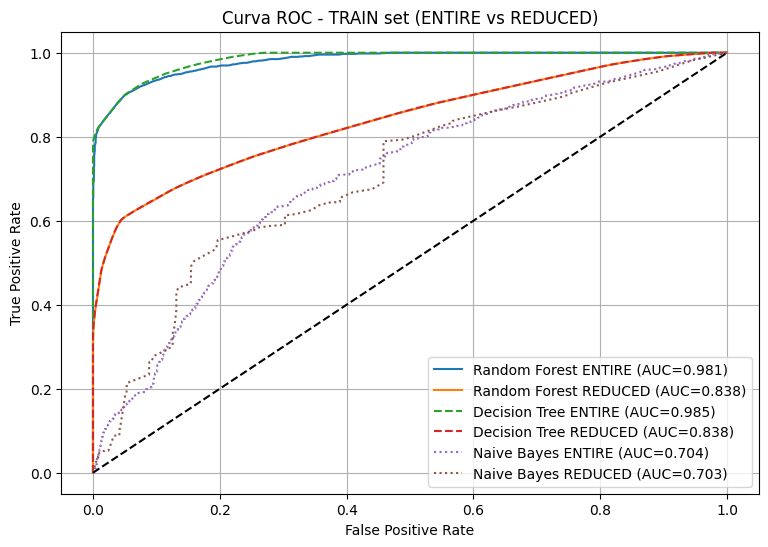

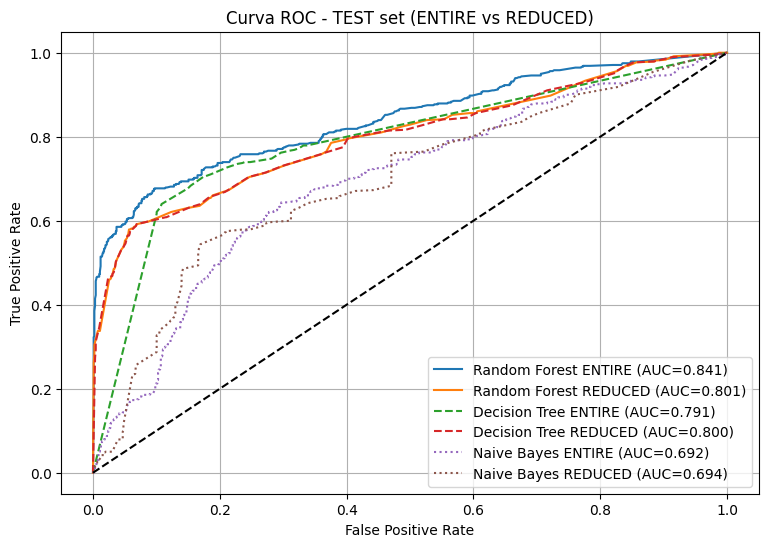

🔹 AUC (Area sotto la curva ROC)
MODELLO               TRAIN_ENTIRE   TEST_ENTIRE   TRAIN_REDUCED    TEST_REDUCED
Naive Bayes                  0.704         0.692           0.703           0.694
Decision Tree                0.985         0.791           0.838           0.800
Random Forest                0.981         0.841           0.838           0.801


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# --- FUNZIONE PER CALCOLARE ROC E AUC ---
def compute_roc_auc(model, X_train, X_test, y_train, y_test):
    y_prob_train = model.predict_proba(X_train)[:, 1]
    y_prob_test = model.predict_proba(X_test)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_prob_train)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_prob_test)
    auc_train = roc_auc_score(y_train, y_prob_train)
    auc_test = roc_auc_score(y_test, y_prob_test)
    return fpr_train, tpr_train, fpr_test, tpr_test, auc_train, auc_test


# --- CALCOLO ROC E AUC PER OGNI MODELLO / DATASET ---

# ENTIRE
roc_nb_entire = compute_roc_auc(nb_entire, X_train_entire, X_test_entire, y_train_entire, y_test_entire)
roc_dt_entire = compute_roc_auc(dt_entire, X_train_entire, X_test_entire, y_train_entire, y_test_entire)
roc_rf_entire = compute_roc_auc(rf_entire, X_train_entire, X_test_entire, y_train_entire, y_test_entire)

# REDUCED
roc_nb_reduced = compute_roc_auc(nb_reduced, X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced)
roc_dt_reduced = compute_roc_auc(dt_reduced, X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced)
roc_rf_reduced = compute_roc_auc(rf_reduced, X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced)


# --- ROC TRAIN – Confronto tra ENTIRE e REDUCED ---
plt.figure(figsize=(9,6))
plt.plot(roc_rf_entire[0], roc_rf_entire[1], label=f'Random Forest ENTIRE (AUC={roc_rf_entire[4]:.3f})')
plt.plot(roc_rf_reduced[0], roc_rf_reduced[1], label=f'Random Forest REDUCED (AUC={roc_rf_reduced[4]:.3f})')
plt.plot(roc_dt_entire[0], roc_dt_entire[1], '--', label=f'Decision Tree ENTIRE (AUC={roc_dt_entire[4]:.3f})')
plt.plot(roc_dt_reduced[0], roc_dt_reduced[1], '--', label=f'Decision Tree REDUCED (AUC={roc_dt_reduced[4]:.3f})')
plt.plot(roc_nb_entire[0], roc_nb_entire[1], ':', label=f'Naive Bayes ENTIRE (AUC={roc_nb_entire[4]:.3f})')
plt.plot(roc_nb_reduced[0], roc_nb_reduced[1], ':', label=f'Naive Bayes REDUCED (AUC={roc_nb_reduced[4]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC - TRAIN set (ENTIRE vs REDUCED)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- ROC TEST – Confronto tra ENTIRE e REDUCED ---
plt.figure(figsize=(9,6))
plt.plot(roc_rf_entire[2], roc_rf_entire[3], label=f'Random Forest ENTIRE (AUC={roc_rf_entire[5]:.3f})')
plt.plot(roc_rf_reduced[2], roc_rf_reduced[3], label=f'Random Forest REDUCED (AUC={roc_rf_reduced[5]:.3f})')
plt.plot(roc_dt_entire[2], roc_dt_entire[3], '--', label=f'Decision Tree ENTIRE (AUC={roc_dt_entire[5]:.3f})')
plt.plot(roc_dt_reduced[2], roc_dt_reduced[3], '--', label=f'Decision Tree REDUCED (AUC={roc_dt_reduced[5]:.3f})')
plt.plot(roc_nb_entire[2], roc_nb_entire[3], ':', label=f'Naive Bayes ENTIRE (AUC={roc_nb_entire[5]:.3f})')
plt.plot(roc_nb_reduced[2], roc_nb_reduced[3], ':', label=f'Naive Bayes REDUCED (AUC={roc_nb_reduced[5]:.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.title("Curva ROC - TEST set (ENTIRE vs REDUCED)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# --- Tabella riepilogativa AUC ---
print("🔹 AUC (Area sotto la curva ROC)")
print(f"{'MODELLO':<20}{'TRAIN_ENTIRE':>14}{'TEST_ENTIRE':>14}{'TRAIN_REDUCED':>16}{'TEST_REDUCED':>16}")
for name, e, r in zip(
    ["Naive Bayes", "Decision Tree", "Random Forest"],
    [roc_nb_entire, roc_dt_entire, roc_rf_entire],
    [roc_nb_reduced, roc_dt_reduced, roc_rf_reduced],
):
    print(f"{name:<20}{e[4]:>14.3f}{e[5]:>14.3f}{r[4]:>16.3f}{r[5]:>16.3f}")

In [5]:
from sklearn.metrics import mean_squared_error

# Dizionari con modelli e dataset
models = {
    'Naive Bayes': (nb_entire, nb_reduced),
    'Decision Tree': (dt_entire, dt_reduced),
    'Random Forest': (rf_entire, rf_reduced)
}

datasets = {
    'ENTIRE': (X_train_entire, y_train_entire, X_test_entire, y_test_entire),
    'REDUCED': (X_train_reduced, y_train_reduced, X_test_reduced, y_test_reduced)
}

# Calcolo MSE su train e test
for dataset_name, (X_train, y_train, X_test, y_test) in datasets.items():
    print(f"\nMSE sul dataset {dataset_name}:")
    for model_name, (model_entire, model_reduced) in models.items():
        model = model_entire if dataset_name == 'ENTIRE' else model_reduced
        
        # Predizione su train
        if hasattr(model, 'predict_proba'):
            y_pred_train = model.predict_proba(X_train)[:, 1]
            y_pred_test = model.predict_proba(X_test)[:, 1]
        else:
            y_pred_train = model.predict(X_train)
            y_pred_test = model.predict(X_test)
        
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        
        print(f"{model_name} - Train MSE: {mse_train:.4f}, Test MSE: {mse_test:.4f} - Overfitting: {((mse_test - mse_train)/mse_train):.4f}%") 


MSE sul dataset ENTIRE:
Naive Bayes - Train MSE: 0.2100, Test MSE: 0.2123 - Overfitting: 0.0106%
Decision Tree - Train MSE: 0.0439, Test MSE: 0.1819 - Overfitting: 3.1453%
Random Forest - Train MSE: 0.0516, Test MSE: 0.1350 - Overfitting: 1.6191%

MSE sul dataset REDUCED:
Naive Bayes - Train MSE: 0.2047, Test MSE: 0.2062 - Overfitting: 0.0070%
Decision Tree - Train MSE: 0.1293, Test MSE: 0.1456 - Overfitting: 0.1262%
Random Forest - Train MSE: 0.1295, Test MSE: 0.1446 - Overfitting: 0.1167%


In [6]:
# Probabilità predette sul dataset reduced
y_probs = rf_reduced.predict_proba(X_test_reduced)[:, 1]

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test_reduced, y_probs)

# Calcolo della soglia ottimale (Youden's J statistic)
J = tpr - fpr
idx = J.argmax()
optimal_threshold = thresholds[idx]

print(f"Soglia ottimale per Random Forest (dataset reduced): {optimal_threshold:.4f}")

Soglia ottimale per Random Forest (dataset reduced): 0.3749


In [ ]:
import pickle
import sklearn

# --- Creazione del pacchetto del modello ---
package = {
    "model": rf_reduced,
    "threshold": optimal_threshold,
    "sklearn_version": sklearn.__version__
}

# --- Salvataggio in formato pickle ---
with open("rf_reduced_package.pkl", "wb") as file:
    pickle.dump(package, file)

print(f"Modello salvato come 'rf_reduced_package.pkl' (scikit-learn {package['sklearn_version']})")

Modello salvato come 'rf_reduced_package.pkl' (scikit-learn 1.7.2)
